
<img src="https://complexity.asu.edu/sites/default/files/comses.jpg" width="500" alt="Comses Logo">

# <u>Using Machine Learning for Spam Detection in CoMSES</u>


At **CoMSES.net**, amongst the many of users and codebases that get uploaded to the site, the influx of spam users and the submission of spam codebases pose several significant challenges.

**Why do we need to address this issue?** :

* **User Experience Disruption**: The presence of spam users and content disrupts the overall user experience on the platform. Legitimate users may find it frustrating to encounter irrelevant or promotional material.

* **Reduced Credibility**: Spam content diminishes the credibility and reliability of the platform. Users may become skeptical about the quality and authenticity of the information and resources available.

* **Resource Drain**: Moderating and manually removing spam submissions demands significant time and effort from platform administrators and moderators, diverting resources away from improving the platform or providing valuable support to the community.

* **Security Concerns**: Some spam content may contain potentially harmful links or code, posing security risks to unsuspecting users who may inadvertently engage with or download such content.

To address these issues effectively, Comses.net is actively developing an advanced spam detection system leveraging machine learning techniques. This system aims to automatically identify and filter out spam submissions, ensuring a cleaner and more enjoyable experience for all users while enhancing the overall credibility and security of the platform.

-------------------------------------------------

# **<u>🤔 What are the different approaches we used to perform the spam detection?</u>**

<img src="https://upload.wikimedia.org/wikipedia/commons/0/05/Scikit_learn_logo_small.svg" width="200" alt="sk-learn"> <img src="https://149695847.v2.pressablecdn.com/wp-content/uploads/2021/06/Hugging-Face.jpg" width="200" alt="Comses Logo">

### To combat spam on our platform, we pursued two strategies:

1. Custom Model Development:

    We built a spam detection model from scratch using scikit learn library, training it on our unique dataset sourced from CoMSES. This approach tailored the model specifically to our platform.

2. Hugging Face Pre-trained Language Models:

    We tapped into the Hugging Face repository, a resource of community-contributed pre-trained models. These models, created by experts, enhanced our spam detection capabilities by leveraging shared knowledge.

<br/>

We will go over what methods are applied in these two directions, but first, let's look into the dataset we use.

-------------------------------------------------

# **<u>🧐 What data is available to perform spam detection?</u>**

Since the user data collected on CoMSES contains privacy information, in this tutorial, we will source the ["SMS Spam Collection Dataset"](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset?resource=download) available on kaggle. The actual CoMSES user dataset have the similer structure as this sample dataset.

In [ ]:
import pandas as pd

dataset = pd.read_csv('spam.csv', header=0,  names=['target', 'text'], usecols=['target', 'text'], encoding='latin-1')
dataset.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


The overall statistics looks like this.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Dataset Size:", len(dataset))
dataset.groupby('target').describe().T

Dataset Size: 5572


target                          ham  \
text count                     4825   
     unique                    4516   
     top     Sorry, I'll call later   
     freq                        30   

target                                                    spam  
text count                                                 747  
     unique                                                653  
     top     Please call our customer service representativ...  
     freq                                                    4

We will conver "ham" into 0 and "spam" into 1, and separate some portion of the dataset for model evaluation purpose.

In [ ]:
dataset['target_n'] = dataset.target.map({'ham':0, 'spam':1})
dataset.head()

,target,text,target_n
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_targets, test_targets = train_test_split(dataset['text'].values, dataset['target_n'].values, test_size=0.2, random_state=0)
print("Training Data Size : ", len(train_texts))
print("Testing Data Size : ", len(test_texts))

Training Data Size :  4457
Testing Data Size :  1115


Now that the dataset is ready let's tap into methods for spam detection.

-------------------------------------------------

# **<u>💪 1. Making our own Custom Model from Scratch </u>**                 
Here are some pros and cons of creating a machine learning model from scratch.

Advantages of using a Custom Model:

* <span style="color:green">Tailored to Specific Needs:</span> Custom models can be fine-tuned to the unique characteristics of the Comses platform, resulting in improved accuracy in identifying spam tailored to the types of content frequently found on the website.

* <span style="color:green">Higher Accuracy Potential:</span> With sufficient data and computational resources, custom models can achieve high accuracy in spam detection as they are designed to focus on platform-specific features and patterns.

* <span style="color:green">Flexibility and Control:</span> Developing a custom model allows for full control over the training process, feature selection, and model architecture, enabling customization and optimization for the specific use case.

* <span style="color:green">Data Privacy:</span> With a custom model, you have greater control over data privacy and can ensure that sensitive user data is handled securely and in compliance with privacy regulations.


Disadvantages of using a Custom Model:

* <span style="color:red">Time-Consuming Development:</span> Developing a custom model from scratch is a time-intensive process. It requires collecting, cleaning, and labeling data, designing and training the model, and fine-tuning parameters.

* <span style="color:red">High Computational Resources:</span> Custom model development can be computationally expensive, expecially for Deep Learning models, requiring powerful hardware, GPUs, and substantial computational resources for training, which may not be readily available.

* <span style="color:red">Environmental Impact:</span> The computational demands of custom model training can contribute to a significant carbon footprint, which may not align with sustainability goals.

* <span style="color:red">Maintenance Overhead:</span> Custom models require ongoing maintenance, updates, and retraining to stay effective as spam tactics evolve. This can lead to ongoing costs and resource commitments.

* <span style="color:red">Potential for Overfitting:</span> Custom models may overfit the training data, leading to reduced generalization performance on unseen data if not carefully managed.

* <span style="color:red">Data Requirements:</span> Building a custom model necessitates a substantial amount of high-quality labeled data. Acquiring and preparing this dataset can be a challenging and resource-intensive task.


## **<u> Methods of Creating Our Custom Model -- Vectorizing Text Data --</u>**

Although text classification is performed well in Deep Learning models, as previously mentioned, the training process can be highly resource-intensive, both time and computational power. Hence, we opted to utilize a traditional machine learning model like Support Vector Machine for our classifier, which demands significantly fewer resources.

However, a challenge arises since many traditional machine learning models cannot directly accept raw text as inputs. Consequently, we need to initially transform the text into numerical vectors, a process known as "vectorization." These vectorized representations of text data can then be used as input for classifiers.

There are two vectorization methods we explored:

    a. Utilizing a basic vectorizer to acquire the numerical representation.  
    b. Adopting a pre-trained Language Model as a vectorizer (embedding).
    

### **<u> a. Utilizing a basic vectorizer to acquire the numerical representation </u>**

We employed CountVectorizer, a vectorizer from the scikit-learn library. Scikit-learn, a widely used Python machine-learning library, encompasses many classic machine-learning techniques like decision trees, support vector machines, nearest neighbors, and more.

CountVectorizer transforms a given text into a vector by analyzing the frequency or count of each word present in the entire text.

Consider the following set of sentences as an example.

In [ ]:
texts = [
        'This is the first document.',
        'This document is the second document.',
        'And this is the third one.',
]

(Sklearn.feature_extraction.text.CountVectorizer — Scikit-Learn 0.20.3 Documentation (2018))


CountVectorizer generates a matrix where every distinct word corresponds to a column, and each text sample from the document forms a row. The value within each cell represents the count of the respective word in that specific text sample. This can be depicted in the following manner:

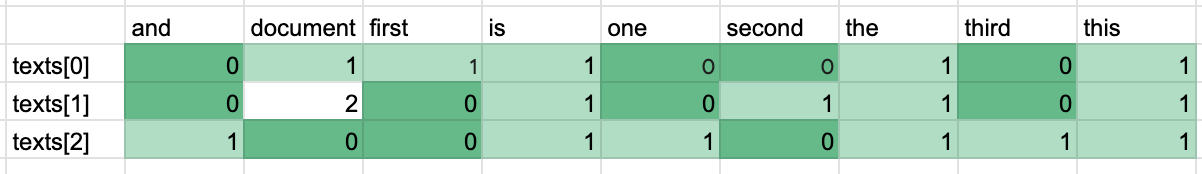

Here is the example on how to use CountVectorizer:

In [ ]:
# example code of CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

texts = [
        'This is the first document.',
        'This document is the second document.',
        'And this is the third one.',
]

# Initialize a Vectorizer Object
example_vectorizer = CountVectorizer()
example_vectorizer.fit(texts)

# Printing the vocabulary registered by Count Vectorizer
print("Vocabulary: ", example_vectorizer.vocabulary_)

# Encode the texts
vectorized_texts = example_vectorizer.transform(texts)

print("Vectorized Texts: ")
print(vectorized_texts.toarray())

Vocabulary:  {'this': 8, 'is': 3, 'the': 6, 'first': 2, 'document': 1, 'second': 5, 'and': 0, 'third': 7, 'one': 4}
Vectorized Texts: 
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]]


Similarly, when we apply CountVectorizer to the spam dataset, we obtain the numerical vector as follows.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
basic_vectorizer = CountVectorizer() # Initialzing CountVectorizer
basic_vectorizer.fit(train_texts) # Fitting the vectorizer to train dataset

print("First 10 Items in Vocabulary: ", list(basic_vectorizer.vocabulary_)[:10])

# Converting texts into numerical vectors
vectorized_train_texts = basic_vectorizer.transform(train_texts)
vectorized_test_texts = basic_vectorizer.transform(test_texts)

print("Vectorized Texts of the Spam Dataset: ")
print(vectorized_train_texts[:3].toarray())

First 10 Items in Vocabulary:  ['no', 'this', 'is', 'kallis', 'home', 'ground', 'amla', 'town', 'durban', 'am']
Vectorized Texts of the Spam Dataset: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Now, we have numerical representations of the texts; we can input these vectors into machine learning models.

### **<u> b. Adopting a pre-trained Large Language Model as a vectorizer (embedding)</u>**

An alternative approach involves utilizing a pre-trained language model from the Internet as our vectorizer. While the subsequent section will elaborate on employing a pre-trained model as a classifier, it's important to note that leveraging a language model to obtain a numerical vector for a text and utilizing it for downstream tasks such as classification is highly prevalent. This technique is called "text embedding."



One of the downsides of using a word vectorizer like CountVectorizer is that when you try to vectorize texts with words that are not registered in the fitting process, those words will be ignored. This means the classifier may miss critical information to decide whether the text is spam.

Another disadvantage is that, since the algorithm is simply counting the number of words, values within a converted vector have nothing to do with each other. In other words, the vectors generated by this method do not contain semantics or contextual information.

Why do we want to capture the contextual information of a text? Let's look into the following example:
    
        1) This mouse likes the blue color
        2) I like this blue color mouse

As a human, we can recognize that the meanings of these two sentences are very different. However, for a traditional machine learning model, they might look similar only because they share most of the words.


Therefore, Large Language Models come in handy.

Large Language Models (LLMs) are deep learning models trained on a broad range of language data to learn universal language representations to comprehend, summarize, and generate texts. These models are pre-trained on a large corpus of text data and are designed to capture a language's general linguistic features, patterns, and structures by adjusting their internal weights.

By understanding the patterns of a large number of texts, LLMs can perform well on various tasks within the field of Natural Language Processing (NLP), and one of such tasks is text embedding. When an LLM is fed a text, it creates a high-dimensional matrix representing the text inside itself. This representation captures the relationship among words and expresses the underlying context. Therefore, simply extracting and using this matrix as our numerical conversion of a text allows us to get a better result on downstream tasks like classification.


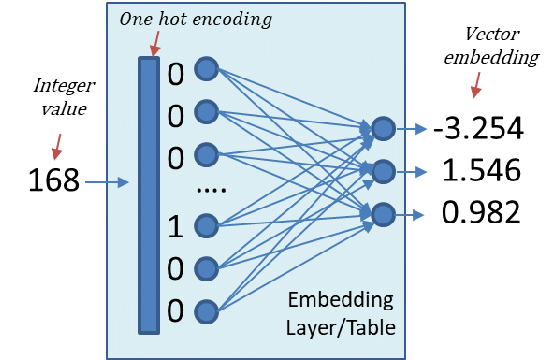

(Fig3 Lopez-Martin et al. (2021))

Popular examples of Language Models includes GPT (Generative Pretrained Transformer) and BERT (Bidirectional Encoder Representations from Transformers).

Here, we leveraged a pre-trained BERT model that is available on the Hugging Face.

In [ ]:
! pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer

# load pre-trained BERT model located on the Hugging Face server
embedding_model = SentenceTransformer('mrm8488/bert-tiny-finetuned-sms-spam-detection')

# Converting texts into numerical vectors
embedded_train_texts = embedding_model.encode(train_texts)
embedded_test_texts = embedding_model.encode(test_texts)

In [ ]:
print("The Shape of the First Embedded Text in the Spam Dataset: ", embedded_train_texts[0].shape)
print("The First 10 Values in the Vector: ", embedded_train_texts[0][:10])

The Shape of the First Embedded Text in the Spam Dataset:  (128,)
The First 10 Values in the Vector:  [-0.18185708  0.66905874 -0.2827111  -0.874812   -0.19271365  1.0922393
 -0.5607006   1.0859791  -1.5640917  -1.8960232 ]


We can see that the first text in the dataset was converted into a vector with 384 values.

### **<u> Perform spam classification on vectorized data </u>**

Finally, let's perform classification on the obtained vectors! For our classification model, we use the Support Vector Machines (SVMs), one of the traditional machine learning methods.

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def svm_classifier(X_train, X_test, y_train, y_test, title):
    svc = svm.SVC(kernel='rbf') # Initialzing SVM classifier
    svc.fit(X_train, y_train)   # Training the classifier
    y_pred_svc = svc.predict(X_test) # Make inference on the test dataset

    # Printing the scores
    print("\n======= " + title + " =======")
    print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred_svc)))
    print("Precision: %.2f%%" % (precision_score(y_test, y_pred_svc)))
    print("Recall: %.2f%%" % (recall_score(y_test, y_pred_svc)))
    print("F1: %.2f%%" % (f1_score(y_test, y_pred_svc)))

In [ ]:
svm_classifier(vectorized_train_texts, vectorized_test_texts, train_targets, test_targets, "CountVectorizer Result")
svm_classifier(embedded_train_texts, embedded_test_texts, train_targets, test_targets, "BERT Embedder Result")


======= CountVectorizer Result =======
Accuracy: 0.98%
Precision: 1.00%
Recall: 0.84%
F1: 0.92%

======= BERT Embedder Result =======
Accuracy: 0.98%
Precision: 0.98%
Recall: 0.91%
F1: 0.94%


Even though both ways of turning texts into vectors give similar results, the BERT Embedder method has a slightly better F1 score. This suggests that with help of the BERT Embedder, the SVM classification model were able to find the right items (True Positives) and doesn't miss many (False Negatives).

-----------------------------------------------------------

# **<u>🤗 2. Using a pre-trained model as classifier</u>**

Here is the list of pros and cons of utilizing an open-sourced machine learning model that was previously trained by scientists.


Advantages:

* <span style="color:green">Efficiency and Time-Saving:</span> Utilizing a pre-trained model from Hugging Face can significantly reduce development time. These models are already trained on vast datasets and can be fine-tuned for specific tasks, saving time and resources.

* <span style="color:green">State-of-the-Art Performance:</span> Hugging Face models often represent the cutting edge of natural language processing (NLP) and machine learning. They have demonstrated exceptional performance on various NLP tasks.

* <span style="color:green">Community Contributions:</span> Hugging Face fosters a collaborative environment where community members contribute pre-trained models. This collective effort expands the variety of models available, catering to diverse use cases.

* <span style="color:green">Resource Efficiency:</span> Pre-trained models are designed to be computationally efficient. They can run on standard hardware, reducing the need for high-end computational resources.

* <span style="color:green">Proven Track Record:</span> Many pre-trained models from Hugging Face have been extensively tested and adopted in real-world applications, providing confidence in their reliability.


Disadvantages:

* <span style="color:red">Limited Customization:</span> While pre-trained models offer efficiency, they may not be as customizable as developing a custom model. Fine-tuning options are available but may have limitations in certain scenarios.

* <span style="color:red">Specific Use Case Alignment:</span> Pre-trained models may not perfectly align with the specific requirements of your use case. Fine-tuning is necessary to adapt them to your unique needs.

* <span style="color:red">Dependency on External Sources:</span> Relying on pre-trained models means depending on external sources, which could introduce potential risks if these sources become unavailable or change.

* <span style="color:red">Model Size:</span> Some pre-trained models can be large in size, which may be a concern if you have limited storage or bandwidth constraints.

* <span style="color:red">Privacy Considerations:</span> Depending on the nature of your data, using pre-trained models may raise privacy concerns, especially if your data contains sensitive information.

* <span style="color:red">Resource Allocation:</span> While pre-trained models are resource-efficient, they still require computational resources for fine-tuning and deployment, which should be considered.


## **<u> Method: How to use a pre-trained model in the easiest way</u>**

* 1. **Install and import the libraries needed:**

In [ ]:
!pip install transformers torch

In [ ]:
from transformers import pipeline

* 2. **Instantiate the classifier:**

The model we used specifically is: https://huggingface.co/mrm8488/bert-tiny-finetuned-sms-spam-detection

In [ ]:
classifier = pipeline("text-classification", model="mrm8488/bert-tiny-finetuned-sms-spam-detection", tokenizer="mrm8488/bert-tiny-finetuned-sms-spam-detection")

* 3. **Test the pre-trained model:**

    Here is a sample of how it is used on some sample text. We are first going to use the following NON spam example:

    **Dr. Jane Smith is a dedicated biomedical researcher with a passion for unraveling the complexities of the human body at the molecular level. With over 15 years of experience in the field, she has established herself as a leading expert in the study of cellular mechanisms and their role in health and disease.**

In [ ]:
result = classifier("Dr. Jane Smith is a dedicated biomedical researcher with a passion for unraveling the complexities of the human body at the molecular level. With over 15 years of experience in the field, she has established herself as a leading expert in the study of cellular mechanisms and their role in health and disease.")
label = result[0]['label'] #store the label in a variable
confidence = result[0]['score'] #store the confidence score in a variable

* 4. **Present the data it in a human readable form:**

In [ ]:
if (label == 'LABEL_1'):
    print("User is spam. Confidence:", confidence)
else:
    print("User is NOT spam. Confidence:", confidence)

User is NOT spam. Confidence: 0.8570489883422852


* 5. **Analyze the data:**

    As we can see, the model correctly identified the user as **NOT SPAM**, with a confidence score of **0.85**

* 6. **Now, lets try giving it a sample SPAM example**

    Let us give it a spam example:
    
    **We are leading Swimming Pool Maintenance Company Dubai. We offer High-End and quality professional services at affordable prices. Call Us Now or Get in Touch: +971 50 219 7300**

    

In [ ]:
result_two = classifier("We are leading Swimming Pool Maintenance Company Dubai. We offer High-End and quality professional services at affordable prices. Call Us Now or Get in Touch: +971 50 219 7300")
label_two = result_two[0]['label'] #store the label in a variable
confidence_two = result_two[0]['score'] #store the confidence score in a variable

In [ ]:
if (label_two == 'LABEL_1'):
    print("User IS spam. Confidence:", confidence_two)
else:
    print("User is NOT spam. Confidence:", confidence_two)

User IS spam. Confidence: 0.8870769143104553


* 7. **Analyaze the data**:

As we can see, the model correctly identified the user as **SPAM**, with a confidence score of **0.89**

-------------------------------------------------

# **<u>⏱️ Comparing the trained models</u>**
In this section, we will show how well the trained models were able to detect sapm on the CoMSES platform. Note that the scores are calculated based on the user data collecected in CoMSES database, not the "SMS Spam Collection Dataset" on kaggle.

Let's prepare our CoMSES dataset:

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

comses_dataset = pd.read_csv('users_with_target.csv', usecols=['is_spam', 'bio'])
comses_dataset = comses_dataset[comses_dataset['bio'].notna()] # extracting samples that have texts in the "bio" field

# Fill NaN values in the 'is_spam' column with 0.0
comses_dataset['is_spam'].fillna(0, inplace=True)
comses_dataset['is_spam'] = comses_dataset['is_spam'].astype(int)

# Split the DataFrame into a training set (90%) and a test set (10%)
train_data, test_data = train_test_split(comses_dataset, test_size=0.1, random_state=42)

# General stats
print("Dataset Size:", len(comses_dataset))
comses_dataset.groupby('is_spam').describe().T

Dataset Size: 426


is_spam                                                     0  \
bio count                                                 287   
    unique                                                285   
    top     I__ a web developer living in unitedstate. I a...   
    freq                                                    3   

is_spam                                                     1  
bio count                                                 139  
    unique                                                139  
    top     Quackquack is one of the best site to find [wh...  
    freq                                                    1

In the CoMSES user dataset, spam users are labeled as 1 in the is_spam column.

First, we run the custom SVM classifer along with the BERT embedder.

In [ ]:
%%time
from sentence_transformers import SentenceTransformer
from sklearn import svm

# load pre-trained BERT model located on the Hugging Face server
embedding_model = SentenceTransformer('mrm8488/bert-tiny-finetuned-sms-spam-detection')

# Converting texts into numerical vectors
embedded_train_bios = embedding_model.encode(train_data['bio'].values)
embedded_test_bios = embedding_model.encode(test_data['bio'].values)

# perform classification
def svm_classifier(X_train, X_test, y_train, y_test):
    svc = svm.SVC(kernel='rbf') # Initialzing SVM classifier
    svc.fit(X_train, y_train)      # Training the classifier
    y_pred_svc = svc.predict(X_test) # Make inference on the test dataset
    return y_pred_svc

predictions = svm_classifier(embedded_train_bios, embedded_test_bios, train_data['is_spam'], test_data['is_spam'])

# Evaluate the model's performance
actual_labels = test_data['is_spam']
classification_report_result = classification_report(actual_labels, predictions)

# Print the classification report
print("\n======= Result of Custom Model with Embedding Processing =======")
print("Accuracy: %.2f%%" % (accuracy_score(actual_labels, predictions)))
print("Precision: %.2f%%" % (precision_score(actual_labels, predictions)))
print("Recall: %.2f%%" % (recall_score(actual_labels, predictions)))
print("F1: %.2f%%" % (f1_score(actual_labels, predictions)))

print("\n======= Execution Time =======")


======= Result of Custom Model with Embedding Processing =======
Accuracy: 0.79%
Precision: 0.68%
Recall: 0.81%
F1: 0.74%

======= Execution Time =======
CPU times: user 5.63 s, sys: 1.32 s, total: 6.94 s
Wall time: 8.85 s


Now, let's check how well the pre-trained model performs on the CoMSES dataset.

In [ ]:
%%time
from transformers import pipeline

# load pre-trained BERT model located on the Hugging Face server
classifier = pipeline("text-classification", model="mrm8488/bert-tiny-finetuned-sms-spam-detection", tokenizer="mrm8488/bert-tiny-finetuned-sms-spam-detection")

# Define a function to classify 'bio' text
def classify_bio(bio):
    bio = str(bio)[:512]

    result = classifier(bio)
    label = result[0]['label']
    confidence = result[0]['score']

    if (label == 'LABEL_1') and (confidence > 0.5):
        return 1
    else:
        return 0

# Apply the classification function to the 'bio' column in the test set
test_data['prediction_pretrained'] = test_data['bio'].apply(classify_bio)

# Extract the actual labels from the test set
actual_labels = test_data['is_spam']

# Print the classification report
print("\n======= Result of Pre-Trained Model: =======")
print("Accuracy: %.2f%%" % (accuracy_score(actual_labels, test_data['prediction_pretrained'])))
print("Precision: %.2f%%" % (precision_score(actual_labels, test_data['prediction_pretrained'])))
print("Recall: %.2f%%" % (recall_score(actual_labels, test_data['prediction_pretrained'])))
print("F1: %.2f%%" % (f1_score(actual_labels, test_data['prediction_pretrained'])))

print("\n======= Execution Time =======")


======= Result of Pre-Trained Model: =======
Accuracy: 0.56%
Precision: 0.42%
Recall: 0.50%
F1: 0.46%

======= Execution Time =======
CPU times: user 410 ms, sys: 6.96 ms, total: 417 ms
Wall time: 518 ms


# <u>**🙌 Conclusion** </u>

It is clear that the custom model outperforms the pre-trained model, which was trained on datasets other than the CoMSES data. However, execution time of the pre-trained classification model is faster. One way to address the low prediction performance of the pre-trained model is to fit model to our dataset. This method is called "fine-tuning."

Our next steps involve fine-tuning the pre-trained classifier to boost prediction accuracy. We'll also focus on efficient operation and maintenance of these models on our server. As spam patterns change over time, we aim to create a continuous training pipeline to keep the spam classifiers effective by adapting to new data types.

#**<u>📖 Reference</u>**
*   sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.20.3 documentation. (2018). Scikit-Learn.org. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
*   Lopez-Martin, M., Carro, B., Arribas, J. I., & Sanchez-Esguevillas, A. (2021). Network intrusion detection with a novel hierarchy of distances between embeddings of hash IP addresses. Knowledge-Based Systems, 219, 106887. https://doi.org/10.1016/j.knosys.2021.106887
